In [48]:
%load_ext autoreload
%autoreload 2

import os
from typing import Any, Tuple, Optional, Union, List
from collections import defaultdict
import random

from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset

import clip

ImageFile.LOAD_TRUNCATED_IMAGES = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Load model and preprocessor
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [30]:
# Load image paths
query_img_paths = [] # dresses' images
for file in os.listdir('../test_images/query'):
    query_fpath = os.path.join('../test_images/query', file)
    query_img_paths.append(query_fpath)
    
doc_img_paths = []  # dildos' images
for root, dirs, files in os.walk('../test_images/doc'):
    for file in files:
        doc_fpath = os.path.join(root, file)
        if os.path.isfile(doc_fpath):
            doc_img_paths.append(doc_fpath)

In [42]:
# sample docs if needed:

doc_img_paths = random.sample(doc_img_paths, 1000)

In [43]:
# Create datasets
class ImageDataset(Dataset):
    def __init__(
        self,
        img_paths: List[str],
        preprocess: Any,
        debug: Union[bool, int] = False
    ):
        self.img_paths = img_paths
        self.length = len(self.img_paths)
        self.preprocess = preprocess
        self.debug = debug

    def __len__(self):
        return self.length

    def __getitem__(
        self,
        idx: int
    ) -> Tuple[Optional[str], Optional[torch.tensor]]:
        img_path = self.img_paths[idx]
        image = Image.open(img_path)

        if image is not None:
            image = image.convert("RGB")
            image = self.preprocess(image)

        return img_path, image

def images_collate(batch):
    batch_paths = []
    batch_images = []
    for image_path, image in batch:
        if image is not None:
            batch_paths.append(image_path)
            batch_images.append(image)
    if len(batch_images) == 0:
        return None, None
    return batch_paths, torch.stack(batch_images)


query_dataset = ImageDataset(
    img_paths=query_img_paths,
    preprocess=preprocess
)

doc_dataset = ImageDataset(
    img_paths=doc_img_paths,
    preprocess=preprocess
)

In [44]:
# Calculate image features
def get_features(dataset, bs):
    all_features = []
    all_labels = []
    dloader = torch.utils.data.DataLoader(dataset, batch_size=bs)

    with torch.no_grad():
        for labels, images in tqdm(dloader):
            features = model.encode_image(images.to(device))
            all_features.append(features)
            all_labels.append(labels)
    return torch.cat(all_features).cpu(), all_labels

query_features, query_labels = get_features(query_dataset)
doc_features, doc_labels = get_features(doc_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:39<00:00, 15.99s/it]


In [45]:
# Get top 5 similar docs for each query
normed_query_features = query_features / query_features.norm(dim=-1, keepdim=True)
normed_doc_features = doc_features / doc_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * normed_query_features @ normed_doc_features.T).softmax(dim=-1)
values, indices = similarity.topk(5, dim=1)

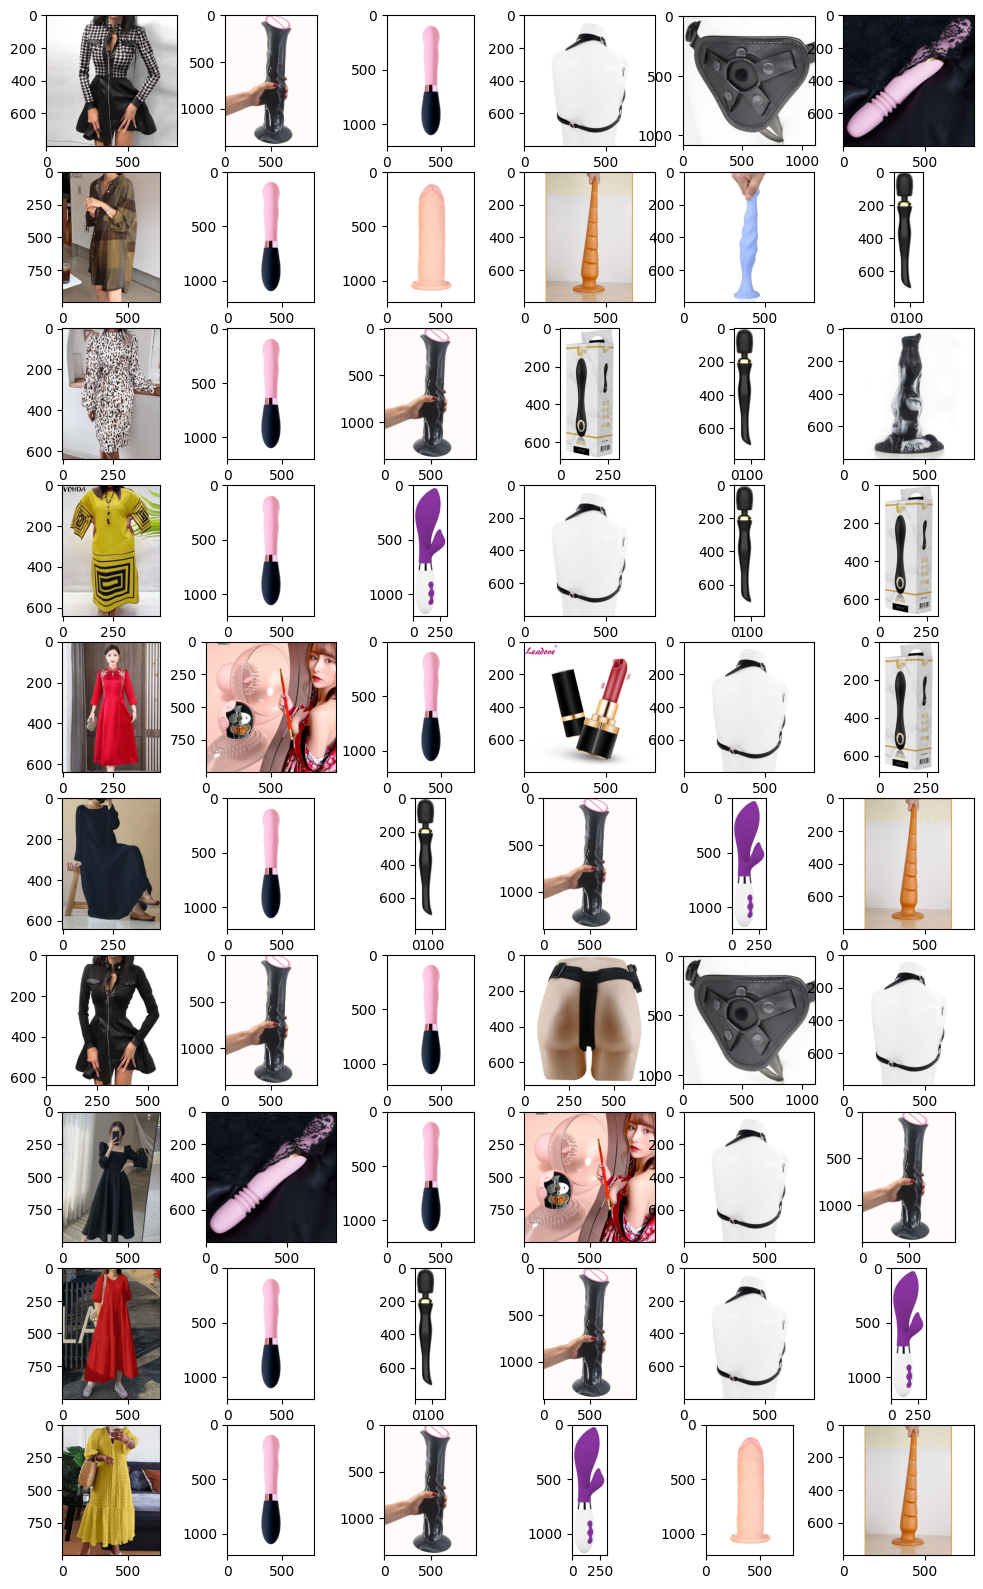

In [46]:
# Plot results
fig, axes = plt.subplots(10, 6, figsize=(12, 20))
for query_idx, doc_indices in enumerate(indices):
    ax = axes[query_idx]
    ax[0].imshow(Image.open(query_img_paths[query_idx]))
    for axi, doc_idx in enumerate(doc_indices):
        ax[axi + 1].imshow(Image.open(doc_img_paths[doc_idx]))